C:\Users\cpeng\AppData\Local\Temp\ipykernel_9468\1983475122.py:389: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ADM_ACTION_DATE'] = pd.to_datetime(df['ADM_ACTION_DATE'], dayfirst=True, errors='coerce')


✔ XGBoost best params: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}

Training Logistic Regression...
Logistic Regression trained successfully.

Training Random Forest...
Random Forest trained successfully.

Training XGBoost...
XGBoost trained successfully.

Training Neural Network (PCA)...
Neural Network (PCA) trained successfully.

Training Naive Bayes...
Naive Bayes trained successfully.

 Model Performance Comparison:
                      Accuracy  Precision    Recall        F1   ROC_AUC
Logistic Regression   0.731619   0.835120  0.707174  0.765840  0.823556
Random Forest         0.840176   0.895252  0.840856  0.867202  0.913543
XGBoost               0.938650   0.952849  0.948060  0.950449  0.984970
Neural Network (PCA)  0.923452   0.920051  0.960085  0.939642  0.973792
Naive Bayes           0.687267   0.739824  0.765186  0.752291  0.748829


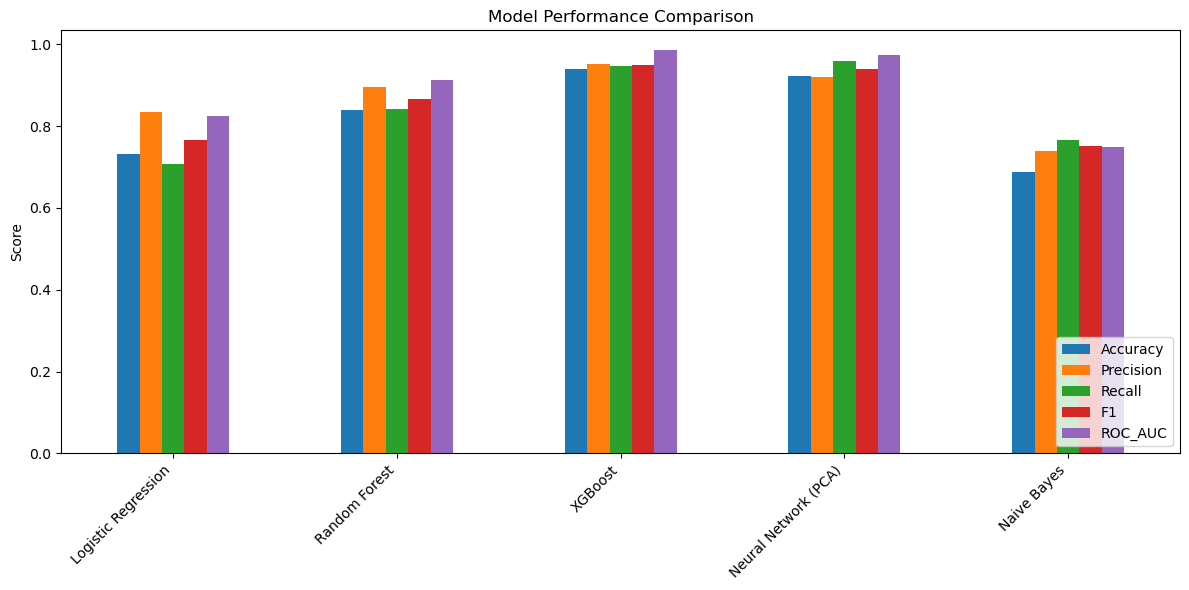

✔ Saved plot → ../results\plots\metrics_comparison.png


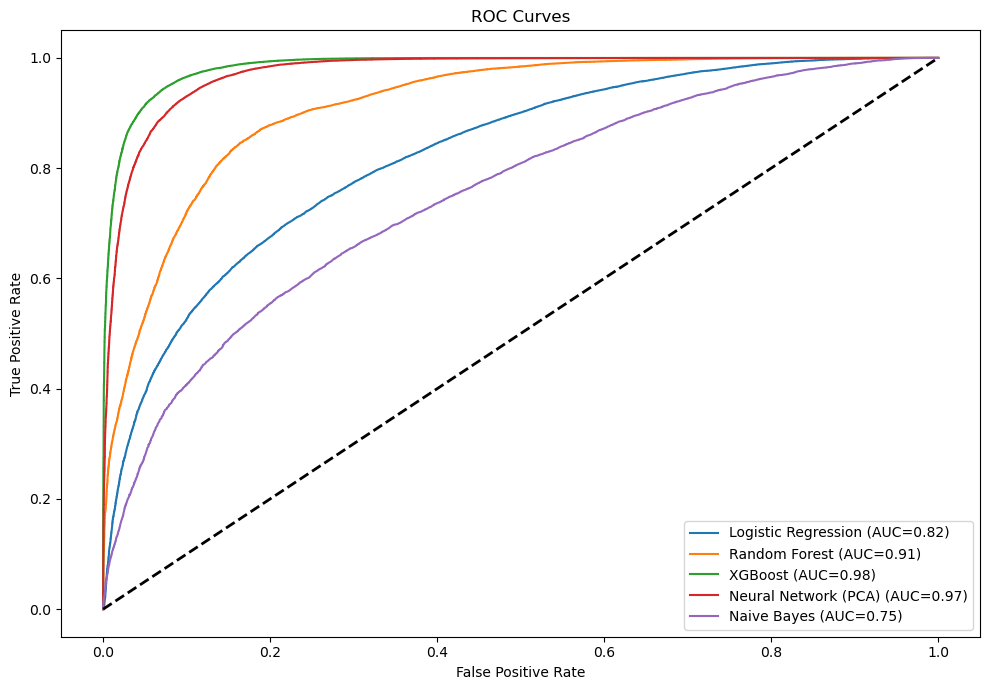

✔ Saved plot → ../results\plots\roc_curves.png

Top 3 Models (ranked by F1):
                      Accuracy  Precision    Recall        F1   ROC_AUC
XGBoost               0.938650   0.952849  0.948060  0.950449  0.984970
Neural Network (PCA)  0.923452   0.920051  0.960085  0.939642  0.973792
Random Forest         0.840176   0.895252  0.840856  0.867202  0.913543


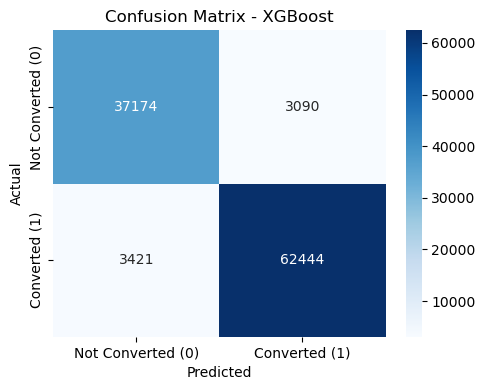

✔ Saved plot → ../results\plots\confusion_matrix_XGBoost.png

Feature Importance - XGBoost:


C:\Users\cpeng\AppData\Local\Temp\ipykernel_9468\1983475122.py:343: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


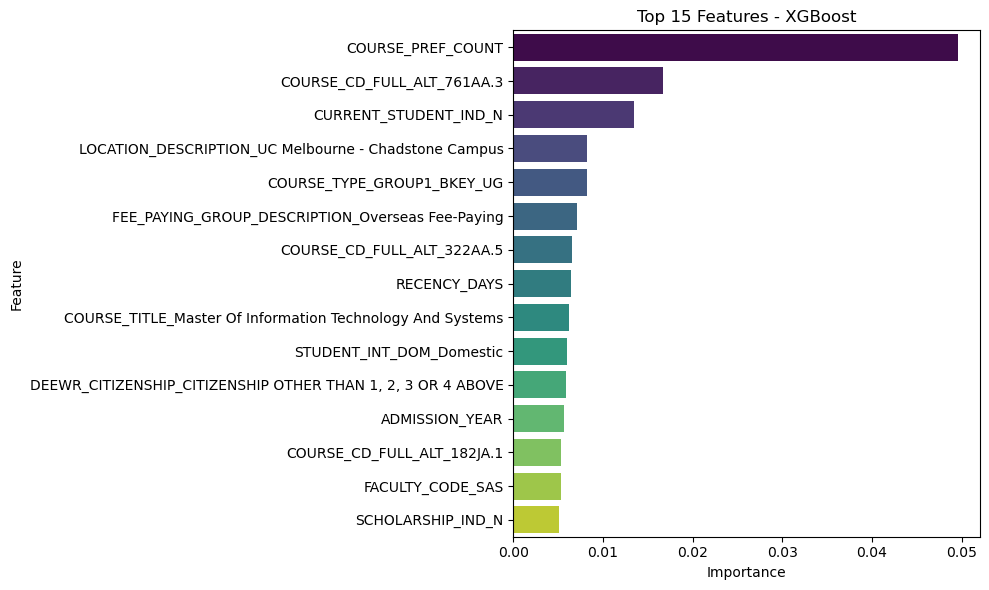

✔ Saved plot → ../results\plots\feature_importance_XGBoost.png
✔ Feature importance CSV saved → ../results\feature_importance_XGBoost.csv

Top 15 Features:
                                                    Feature  Importance
                                          COURSE_PREF_COUNT    0.049552
                                 COURSE_CD_FULL_ALT_761AA.3    0.016669
                                      CURRENT_STUDENT_IND_N    0.013425
       LOCATION_DESCRIPTION_UC Melbourne - Chadstone Campus    0.008263
                                 COURSE_TYPE_GROUP1_BKEY_UG    0.008248
           FEE_PAYING_GROUP_DESCRIPTION_Overseas Fee-Paying    0.007147
                                 COURSE_CD_FULL_ALT_322AA.5    0.006591
                                               RECENCY_DAYS    0.006427
  COURSE_TITLE_Master Of Information Technology And Systems    0.006191
                                   STUDENT_INT_DOM_Domestic    0.006017
DEEWR_CITIZENSHIP_CITIZENSHIP OTHER THAN 1, 2, 3 OR 

In [1]:
# ===============================
# Imports
# ===============================
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import argparse
import joblib
from joblib import dump
from matplotlib import colormaps

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer




# ===============================
# Feature Engineering
# ===============================
def add_features(df):
    df_model = df.copy()

    # AGE_RANGE → numeric midpoint
    
    
    def age_midpoint(age_range):
        try:
            s = str(age_range).strip().lower()
            if "-" in s:  # e.g. "18-24"
                lo, hi = map(int, re.findall(r"\d+", s))
                return (lo + hi) / 2
            elif "to" in s:  # e.g. "18 to 24"
                lo, hi = map(int, re.findall(r"\d+", s))
                return (lo + hi) / 2
            elif "+" in s:  # e.g. "65+"
                return int(re.findall(r"\d+", s)[0])
            elif s.isdigit():  # single age
                return int(s)
            else:
                return np.nan
        except:
            return np.nan

    df_model["AGE_NUM"] = df_model["AGE_RANGE"].apply(age_midpoint)
    # SEX → One-hot
    df_model = pd.get_dummies(df_model, columns=["SEX"], prefix="SEX", drop_first=True)

    # Domestic flag
    df_model["IS_DOMESTIC"] = df_model["STUDENT_INT_DOM"].map(lambda x: 1 if str(x).lower().startswith("dom") else 0)

    # Flags
    df_model["HAS_SCHOLARSHIP"] = df_model["SCHOLARSHIP_IND"].map(lambda x: 1 if str(x) == "Y" else 0)
    df_model["HAS_DISABILITY"] = df_model["DISABILITY_IND"].map(lambda x: 1 if str(x) == "Y" else 0)
    df_model["IS_CURRENT_STUDENT"] = df_model["CURRENT_STUDENT_IND"].map(lambda x: 1 if str(x) == "Y" else 0)
    df_model["IS_RESEARCH_STUDENT"] = df_model["RESEARCH_STUDENT_IND"].map(lambda x: 1 if str(x) == "Y" else 0)
    df_model["IS_AUS_CAMPUS"] = df_model["AUSTRALIAN_CAMPUS_FLAG"].map(lambda x: 1 if str(x) == "Y" else 0)
    df_model["IS_ATSI"] = df_model[["ABORIG_TORRES", "ATSI_IND"]].apply(lambda row: 1 if "Y" in row.values else 0, axis=1)

    # Faculty grouping
    top_faculties = df_model["FACULTY_DESCRIPTION"].value_counts().nlargest(5).index
    df_model["FACULTY_GROUPED"] = df_model["FACULTY_DESCRIPTION"].apply(lambda x: x if x in top_faculties else "Other")
    df_model = pd.get_dummies(df_model, columns=["FACULTY_GROUPED"], prefix="FACULTY", drop_first=True)

    # Course flags and grouping
    df_model["IS_RESEARCH_COURSE"] = df_model["RESEARCH_COURSE_FLAG"].map(lambda x: 1 if str(x) == "Y" else 0)
    df_model["IS_UCC_COURSE"] = df_model["UCC_COURSE_FLAG"].map(lambda x: 1 if str(x) == "Y" else 0)
    top_courses = df_model["COURSE_CD_FULL_ALT"].value_counts().nlargest(10).index
    df_model["COURSE_GROUPED"] = df_model["COURSE_CD_FULL_ALT"].apply(lambda x: x if x in top_courses else "Other")
    df_model = pd.get_dummies(df_model, columns=["COURSE_GROUPED"], prefix="COURSE", drop_first=True)

    # Course status
    if "COURSE_STATUS" in df_model.columns:
        df_model = pd.get_dummies(df_model, columns=["COURSE_STATUS"], prefix="CSTATUS", drop_first=True)

    # Engagement features
    df_model["ADM_ACTION_DATE"] = pd.to_datetime(df_model["ADM_ACTION_DATE"], errors="coerce")
    first_action = df_model.groupby("PERSONID")["ADM_ACTION_DATE"].transform("min")
    df_model["DAYS_TO_ENROLL"] = (df_model["ADM_ACTION_DATE"] - first_action).dt.days
    course_counts = df.groupby(["PERSONID", "COURSE_CD_FULL_ALT"]).size().reset_index(name="COURSE_PREF_COUNT")
    df_model = df_model.merge(course_counts, on=["PERSONID", "COURSE_CD_FULL_ALT"], how="left")
    last_action = df_model.groupby("PERSONID")["ADM_ACTION_DATE"].transform("max")
    df_model["RECENCY_DAYS"] = (last_action - df_model["ADM_ACTION_DATE"]).dt.days
    df_model["AVG_ACTION_GAP"] = df_model.groupby("PERSONID")["ADM_ACTION_DATE"].transform(
        lambda x: x.diff().mean().days if x.nunique() > 1 else 0
    )

    # Person-level target
    df_model["lead_target"] = df_model["ADM_ACTION_DETAIL_GROUP"].str.upper().isin(["ENROL", "ACCEPT"]).astype(int)
    df_target = df_model.groupby("PERSONID", as_index=False)["lead_target"].max()
    df_model = df_model.drop(columns=["lead_target"]).merge(df_target, on="PERSONID", how="left")

    return df_model

# ===============================
# Preprocessing
# ===============================


def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop(columns=['Unnamed: 0', 'PERSONID', 'COURSE_CD', 'COURSE_VERSION',
                          'ADM_ACTION_DETAIL_DESCRIPTION', 'HOME_COUNTRY',
                          'RES_AUS_POSTCODE', 'MAILING_POSTCODE'], errors='ignore')
    
    df = df.drop_duplicates().reset_index(drop=True)

    # ------------------------
    # Remove rows with invalid values
    # ------------------------
    invalid_condition = (
        (df['BIRTH_COUNTRY'].isin(['NO INFORMATION ON COUNTRY OF BIRTH'])) |
        (df['STUDENT_INT_DOM'] == 'Not Specified') |
        (df['FEE_PAYING_GROUP_DESCRIPTION'] == '<<Unknown>>') |
        (df['LOCATION_TYPE'] == '<<Unknown>>') |
        (df['LOCATION_DESCRIPTION'] == '<<Unknown>>') |
        (df['LOCATION_COUNTRY'] == '<<Unknown>>') |        
        (df['DEEWR_CITIZENSHIP'].isin([
            'NO INFORMATION ON STUDENT CITIZENSHIP', 'Not Specified'
        ])) |
        (df['ABORIG_TORRES'] == 'Not Specified')
    )
    df = df[~invalid_condition].copy()
    # -------------------------
    # Keep only valid COURSE_TYPE_GROUP1_BKEY values
    # -------------------------
    valid_course_types = ["PG", "UG", "NAWD"]
    df['COURSE_TYPE_GROUP1_BKEY'] = df['COURSE_TYPE_GROUP1_BKEY'].astype(str).str.strip().str.upper()
    df = df[df['COURSE_TYPE_GROUP1_BKEY'].isin(valid_course_types)].reset_index(drop=True)

    # -------------------------
    # Drop rows with missing AGE_NUM
    # -------------------------
    if 'AGE_NUM' in df.columns:
        df = df.dropna(subset=['AGE_NUM']).reset_index(drop=True)
        
    # -------------------------
    # Prepare features and target
    # -------------------------
    X = df.drop(columns=['ADM_ACTION_DETAIL_GROUP', 'lead_target'], errors='ignore')
    y = df['lead_target']

    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features),
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features)
        ]
    )

    return X, y, preprocessor



# ===============================
# Model Definitions
# ===============================
def get_models(preprocessor, categorical_features, y_train):
    preprocessor_nb = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
    ratio = (len(y_train)-sum(y_train))/sum(y_train)
    pca = PCA(n_components=50, random_state=42)

    models = {
        'Logistic Regression': Pipeline([('preprocessor', preprocessor),
                                         ('classifier', LogisticRegression(max_iter=1000,class_weight='balanced'))]),
        'Random Forest': Pipeline([('preprocessor', preprocessor),
                                   ('classifier', RandomForestClassifier(n_estimators=100,max_depth=15,
                                                                         min_samples_split=10,random_state=42,
                                                                         n_jobs=-1,class_weight='balanced'))]),
        'XGBoost': Pipeline([('preprocessor', preprocessor),
                             ('classifier', XGBClassifier(n_estimators=300,learning_rate=0.1,
                                                         max_depth=5,subsample=0.8,colsample_bytree=0.8,
                                                         scale_pos_weight=ratio,eval_metric='auc',
                                                         random_state=42,n_jobs=-1))]),
        'Neural Network (PCA)': Pipeline([('preprocessor', preprocessor),('pca',pca),
                                          ('classifier', MLPClassifier(hidden_layer_sizes=(50,),
                                                                       max_iter=200,random_state=42,
                                                                       early_stopping=True,n_iter_no_change=10,
                                                                       learning_rate_init=0.01,verbose=False))]),
        'Naive Bayes': Pipeline([('preprocessor', preprocessor_nb),
                                 ('classifier', MultinomialNB())])
    }

    param_grids = {
        'XGBoost': {'classifier__n_estimators':[100,200,300],'classifier__max_depth':[3,5,7],
                    'classifier__learning_rate':[0.01,0.1,0.2],'classifier__subsample':[0.8,1.0],
                    'classifier__colsample_bytree':[0.8,1.0]}
    }

    return models, param_grids

# ===============================
# Lead Score Categorization
# ===============================
def categorize_lead(score):
    if score >= 80: return "Hot"
    elif score >= 50: return "Warm"
    else: return "Cold"

# ===============================
# Evaluation & Scoring
# ===============================
def evaluate_and_score(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else None

    results = {'Accuracy':accuracy_score(y_test,y_pred),
               'Precision':precision_score(y_test,y_pred,zero_division=0),
               'Recall':recall_score(y_test,y_pred,zero_division=0),
               'F1':f1_score(y_test,y_pred,zero_division=0)}
    if y_prob is not None:
        results['ROC_AUC'] = roc_auc_score(y_test,y_prob)

    scored_df = X_test.copy()
    scored_df['Actual'] = y_test.values
    scored_df['Predicted'] = y_pred
    scored_df['Lead Score'] = (y_prob*100).round(2) if y_prob is not None else 0
    scored_df['Category'] = scored_df['Lead Score'].apply(categorize_lead)

    return results, scored_df

# ===============================
# Plotting Functions
# ===============================
def save_plot(fig, filename, results_dir):
    path = os.path.join(results_dir,'plots',filename)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path)
    plt.close(fig)
    print(f"✔ Saved plot → {path}")

def plot_metrics(results_df, results_dir):
    metrics_to_plot = ['Accuracy','Precision','Recall','F1','ROC_AUC']
    fig, ax = plt.subplots(figsize=(12,6))
    results_df[metrics_to_plot].plot(kind='bar',ax=ax)
    ax.set_title("Model Performance Comparison")
    ax.set_ylabel("Score")
    ax.set_xticklabels(results_df.index,rotation=45,ha='right')
    ax.legend(loc='lower right')
    fig.tight_layout()
    plt.show()
    save_plot(fig,'metrics_comparison.png',results_dir)

def plot_roc_curves(models,X_test,y_test,results_dir):
    fig, ax = plt.subplots(figsize=(10,7))
    for name, model in models.items():
        try:
            if hasattr(model,"predict_proba"):
                y_prob = model.predict_proba(X_test)[:,1]
                fpr,tpr,_ = roc_curve(y_test,y_prob)
                roc_auc = auc(fpr,tpr)
                ax.plot(fpr,tpr,label=f"{name} (AUC={roc_auc:.2f})")
        except: continue
    ax.plot([0,1],[0,1],'k--',lw=2)
    ax.set_title("ROC Curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    fig.tight_layout()
    plt.show()
    save_plot(fig,'roc_curves.png',results_dir)

def plot_confusion_matrix(model,X_test,y_test,model_name,results_dir):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    labels = ['Not Converted (0)','Converted (1)']
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels,ax=ax)
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    fig.tight_layout()
    plt.show()
    save_plot(fig,f'confusion_matrix_{model_name.replace(" ","_")}.png',results_dir)


# ===============================
# Feature Importance
# ===============================
def plot_feature_importance(model, preprocessor, X, model_name="Model", results_dir="results", save_csv=False):
    try:
        # Get feature names
        cat_features = preprocessor.transformers_[0][1].get_feature_names_out(
            preprocessor.transformers_[0][2]
        )
        num_features = preprocessor.transformers_[1][2]
        feature_names = np.concatenate([cat_features, num_features])

        # Get importances
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_[0])
        else:
            print(f"  {model_name} does not provide feature importances.")
            return None

        # Full DataFrame (all features, not just top-N)
        fi_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by="Importance", ascending=False)

        # --- Save CSV with all features ---
        if save_csv:
            csv_path = os.path.join(results_dir, f'feature_importance_{model_name.replace(" ","_")}.csv')
            fi_df.to_csv(csv_path, index=False)
            print(f"✔ Saved feature importance CSV → {csv_path}")

        # --- Plot only top 15 features ---
        top_fi = fi_df.head(15)
        fig, ax = plt.subplots(figsize=(10, 6))
        cmap = colormaps.get_cmap("viridis")
        colors = [cmap(i / len(top_fi)) for i in range(len(top_fi))]

        sns.barplot(
            x="Importance",
            y="Feature",
            data=top_fi,
            palette=colors,
            ax=ax,
            dodge=False,
            legend=False
        )

        ax.set_title(f"Top 15 Features - {model_name}")
        fig.tight_layout()
        plt.show()
        save_plot(fig, f'feature_importance_{model_name.replace(" ","_")}.png', results_dir)        
        plt.close(fig)

        return fi_df
    except Exception as e:
        print(f"  Could not plot feature importance for {model_name}: {e}")
        return None


# ===============================
# Rank Top Models
# ===============================
def rank_top_models(results_df, metric='F1', top_n=3):
    ranked = results_df.sort_values(by=metric, ascending=False).head(top_n)
    print(f"\nTop {top_n} Models (ranked by {metric}):")
    print(ranked)
    return ranked

# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    data_path = "../data/Anonymised - 20250925_capstone_admissions.csv"   
    results_dir = "../results"
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(os.path.join(results_dir, "plots"), exist_ok=True)  

    
    mode = "develop"   # or "usage" 

    # Load and preprocess dataset
    # 2. Load dataset
    df = pd.read_csv(data_path)
    df['ADM_ACTION_DATE'] = pd.to_datetime(df['ADM_ACTION_DATE'], dayfirst=True, errors='coerce')
    df = add_features(df)  #  feature engineering function

    

    if mode == "develop":
        
        # Preprocess features
        X, y, preprocessor = preprocess_data(df)  # Returns X, y, preprocessor
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()

        # Get models and parameter grids
        models, param_grids = get_models(preprocessor, categorical_features, y_train)

        # GridSearch for XGBoost
        if 'XGBoost' in models:
            xgb_grid = GridSearchCV(
                models['XGBoost'],
                param_grids['XGBoost'],
                cv=3,
                scoring='f1',
                n_jobs=1
            )
            xgb_grid.fit(X_train, y_train)
            models['XGBoost'] = xgb_grid.best_estimator_
            print("✔ XGBoost best params:", xgb_grid.best_params_)

        all_results, scored_outputs, fitted_models = {}, {}, {}

        
        # Train & Evaluate all models
        for name, model in models.items():
            try:
                print(f"\nTraining {name}...")
                results, scored_df = evaluate_and_score(model, X_train, X_test, y_train, y_test)
                all_results[name] = results
                scored_outputs[name] = scored_df
                fitted_models[name] = model
                print(f"{name} trained successfully.")
            except Exception as e:
                print(f"  {name} failed: {e}")
    
        results_df = pd.DataFrame(all_results).T
        print("\n Model Performance Comparison:")
        print(results_df)
    
        # Visualizations
        plot_metrics(results_df, results_dir)
        plot_roc_curves(fitted_models, X_test, y_test, results_dir)
        
        # Rank Top Models
        top_models = rank_top_models(results_df, metric='F1', top_n=3)

        # Feature Importance & Confusion Matrix only for the best model
        best_model_name = top_models.index[0]
        best_model = fitted_models[best_model_name]

        # Confusion matrix (only for best model)
        plot_confusion_matrix(best_model, X_test, y_test, best_model_name, results_dir)

        
        # Feature importance (only for best model)
        try:
            print(f"\nFeature Importance - {best_model_name}:")
            fi = plot_feature_importance(
            best_model.named_steps['classifier'],
            preprocessor,
            X,
            model_name=best_model_name,
            results_dir=results_dir
            )
            if fi is not None:
                # Save full feature importance CSV (sorted descending)
                fi_path = os.path.join(results_dir, f'feature_importance_{best_model_name.replace(" ","_")}.csv')
                fi.to_csv(fi_path, index=False)
                print(f"✔ Feature importance CSV saved → {fi_path}")

                # Print top 15 features to console
                print("\nTop 15 Features:")
                print(fi.head(15).to_string(index=False))
        except Exception as e:
            print(f" Skipping feature importance for {best_model_name}: {e}")



        # Ensure model folder exists inside project root
        # Handle Jupyter/Notebook vs Script execution
        try:
            base_dir = os.path.dirname(__file__)
        except NameError:
            base_dir = os.getcwd()   # fallback if __file__ not defined

        model_dir = os.path.join(base_dir, "..", "model")
        os.makedirs(model_dir, exist_ok=True)


        # Save best model
        best_model_path = os.path.join(model_dir, "best_model_20250925_capstone_admissions.pkl")
        dump(best_model, best_model_path)

        print(f"✔ Best model ({best_model_name}) saved → {best_model_path}")


    elif mode == "usage":
        import joblib
        # Load best model
        # Model folder path
        model_dir = os.path.join(os.path.dirname(__file__), "..", "model")
        best_model_path = os.path.join(model_dir, "best_model_20250925_capstone_admissions.pkl")

        # Load model
        best_model = joblib.load(best_model_path)
        print(f" Loaded model from {best_model_path}")

        

        # Prepare data for scoring
        X_new = df.drop(columns=['ADM_ACTION_DETAIL_GROUP', 'lead_target'], errors='ignore')
        y_prob = best_model.predict_proba(X_new)[:, 1]
        df["Lead Score"] = (y_prob * 100).round(2)
        df["Predicted Lead"] = (y_prob >= 0.5).astype(int)
        df["Category"] = df["Lead Score"].apply(categorize_lead)

        # Aggregate at PERSONID level
        person_scores = df.groupby("PERSONID").agg({
            "Lead Score": "mean",
            "Predicted Lead": "max",
            "Category": lambda x: x.mode()[0] if not x.mode().empty else "Cold",
            "lead_target": "max"
        }).reset_index()

        # Save scored leads
        person_scores.to_csv(os.path.join(results_dir, "scored_leads.csv"), index=False)
        print(" Scored leads saved in scored_leads.csv")
        print("\nSample scored leads:")
        print(person_scores.head())


